In [246]:
import pandas as pd
import numpy as np
import xgboost as xgb
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix

In [ ]:
os.makedirs("models", exist_ok=True)
os.makedirs("visualizations", exist_ok=True)

map_files = glob("datasets/consolidated_data/*_kill_data_consolidated.csv")
print(f'Found {len(map_files)} map data files:")
for file in map_files:
    print(f"- {os.path.basename(file)}")

Found 9 map data files:
- ascent_kill_data_consolidated.csv
- lotus_kill_data_consolidated.csv
- split_kill_data_consolidated.csv
- fracture_kill_data_consolidated.csv
- icebox_kill_data_consolidated.csv
- haven_kill_data_consolidated.csv
- pearl_kill_data_consolidated.csv
- abyss_kill_data_consolidated.csv
- bind_kill_data_consolidated.csv


In [264]:
def calculate_weapon_distance_advantage(attacker_weapon_id, defender_weapon_id, distance):
    """
    Calculate advantage based on weapon types at a given distance.
    Returns a numerical advantage score (positive favors attacker, negative favors defender).
    """
    extremely_short_range = [1]  # Knife
    short_range = [14, 7, 6]  # Shorty, Judge, Bucky
    short_mid_range = [11, 10, 12, 19, 18]  # Classic, Frenzy, Ghost, Stinger, Spectre
    mid_range = [13, 5, 3, 2]  # Sheriff, Bulldog, Ares, Odin
    mid_long_range = [16, 6, 4]  # Guardian, Phantom, Vandal
    long_range = [17, 15, 23]  # Marshal, Operator, Outlaw
    
    def get_weapon_category(weapon_id):
        weapon_id = float(weapon_id) if isinstance(weapon_id, str) else weapon_id
        
        if weapon_id in extremely_short_range:
            return "extremely_short_range"
        elif weapon_id in short_range:
            return "short_range"
        elif weapon_id in short_mid_range:
            return "short_mid_range"
        elif weapon_id in mid_range:
            return "mid_range"
        elif weapon_id in mid_long_range:
            return "mid_long_range"
        elif weapon_id in long_range:
            return "long_range"
        else:
            return "unknown"
    
    attacker_category = get_weapon_category(attacker_weapon_id)
    defender_category = get_weapon_category(defender_weapon_id)
    
    # Calculate advantage based on distance
    if distance < 50:  # Extremely short range (~5m)
        advantage_map = {
            "extremely_short_range": 3,  # Strong advantage
            "short_range": 2,  # Moderate advantage
            "short_mid_range": 1,  # Slight advantage
            "mid_range": -1,  # Disadvantage
            "mid_long_range": -2,  # Significant disadvantage
            "long_range": -3,  # Severe disadvantage
            "unknown": 0  # No impact
        }
    elif distance < 150:  # Short range (~15m)
        advantage_map = {
            "extremely_short_range": 1,
            "short_range": 3,
            "short_mid_range": 2,
            "mid_range": 0,
            "mid_long_range": -1,
            "long_range": -2,
            "unknown": 0
        }
    elif distance < 300:  # Mid range (~30m)
        advantage_map = {
            "extremely_short_range": -2,
            "short_range": -1,
            "short_mid_range": 0,
            "mid_range": 3,
            "mid_long_range": 2,
            "long_range": 1,
            "unknown": 0
        }
    else:  # Long range (30m+)
        advantage_map = {
            "extremely_short_range": -3,
            "short_range": -3,
            "short_mid_range": -2,
            "mid_range": -1,
            "mid_long_range": 2,
            "long_range": 3,
            "unknown": 0
        }
    
    attacker_advantage = advantage_map.get(attacker_category, 0)
    defender_advantage = advantage_map.get(defender_category, 0)
    
    return attacker_advantage - defender_advantage

In [274]:
def train_map_model(file_path):
    map_name = os.path.basename(file_path).split("_")[0]
    print(f"Training model for {map_name}...")
    df = pd.read_csv(file_path)
    print(f"Loaded {len(df)} rows of data.")
    
    initial_rows = len(df)
    df = df.dropna(subset=["killer_x", "killer_y", "victim_x", "victim_y", "side", "killer_loadout_value", "victim_loadout_value"])
    print(f"Dropped {initial_rows - len(df)} rows with missing data")
    
    df.fillna({
        "plant_time": df["time"].max() + 1000,
    }, inplace=True)
    
    # ===== Feature Engineering =====
    # distance between killer and victim
    df["distance"] = np.sqrt((df["killer_x"] - df["victim_x"])**2 + (df["killer_y"] - df["victim_y"])**2)
    
    # difference between killer and victim loadout values
    df["loadout_advantage"] = df["killer_loadout_value"] - df["victim_loadout_value"]
    
    df["weapon_distance_advantage"] = df.apply(
        lambda row: calculate_weapon_distance_advantage(
            row.killer_weapon_id, 
            row.victim_weapon_id, 
            row.distance
        ), 
        axis=1
    )
    
    # defenders in general have an advantage for the first 20 seconds of the round, then neutral,
    # then attackers have an advantage after the bomb is planted. This is a rough guess.
    early_round_time = 20000
    df["is_early_round"] = (df["time"] < early_round_time).astype(int)
    df["is_post_plant"] = ((df["plant_time"] != df["time"].max() + 1000) & 
                           (df["time"] > df["plant_time"])).astype(int)
    df["time_advantage"] = np.where(
        df["is_post_plant"] == 1, 
        -1,  # Post-plant: attacker advantage
        np.where(
            df["is_early_round"] == 1,
            1,  # Early round: defender advantage
            0   # Mid-round: neutral
        )
    )
    
    # ===== Target =====
    # Target: did attacker win this engagement?
    df["attacker_won"] = (df["side"] == "atk").astype(int)
    
    features = [
        "killer_x", "killer_y", "victim_x", "victim_y", "distance",  # Spatial
        "loadout_advantage", "weapon_distance_advantage",            # Economic
        "time_advantage"                                             # Timing
    ]
    
    X = df[features].copy()
    y = df["attacker_won"]
    
    # ===== Train-Test Split by match ID =====
    match_ids = df["match_id"].unique()
    train_matches, test_matches = train_test_split(match_ids, test_size=0.2, random_state=42)
    
    train_mask = df["match_id"].isin(train_matches)
    test_mask = df["match_id"].isin(test_matches)
    
    X_train = X[train_mask]
    y_train = y[train_mask]
    X_test = X[test_mask]
    y_test = y[test_mask]
    
    model = xgb.XGBClassifier(
        max_depth=4,
        learning_rate=0.1,
        n_estimators=100,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"Model Accuracy: {accuracy:.4f}")
    
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
               xticklabels=["Defender Win", "Attacker Win"],
               yticklabels=["Defender Win", "Attacker Win"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix for {map_name.capitalize()}")
    plt.tight_layout()
    plt.savefig(f"visualizations/{map_name}_confusion_matrix.png")
    plt.close()
    
    model_path = f"models/{map_name}.json"
    model.save_model(model_path)
    print(f"Model saved to {model_path}")
    
    feature_dict = {
        "features": features,
        "has_site_data": False
    }
    
    return model, accuracy, feature_dict, map_name

In [281]:
os.makedirs("models", exist_ok=True)
os.makedirs("visualizations", exist_ok=True)

results = []
models = {}
feature_configs = {}

for file in map_files:
    model, accuracy, feature_dict, map_name = train_map_model(file)
    models[map_name] = model

Training model for ascent...
Loaded 5829 rows of data.
Dropped 56 rows with missing data
Model Accuracy: 0.7511
Model saved to models/ascent.json
Training model for lotus...
Loaded 14403 rows of data.
Dropped 146 rows with missing data
Model Accuracy: 0.7816
Model saved to models/lotus.json
Training model for split...
Loaded 11583 rows of data.
Dropped 103 rows with missing data
Model Accuracy: 0.7843
Model saved to models/split.json
Training model for fracture...
Loaded 8807 rows of data.
Dropped 72 rows with missing data
Model Accuracy: 0.6940
Model saved to models/fracture.json
Training model for icebox...
Loaded 6530 rows of data.
Dropped 58 rows with missing data
Model Accuracy: 0.8601
Model saved to models/icebox.json
Training model for haven...
Loaded 10682 rows of data.
Dropped 72 rows with missing data
Model Accuracy: 0.7632
Model saved to models/haven.json
Training model for pearl...
Loaded 10544 rows of data.
Dropped 110 rows with missing data
Model Accuracy: 0.8086
Model sa

In [282]:
def predict_duel(model, attacker_pos, defender_pos, 
                attacker_loadout, defender_loadout, 
                round_time, plant_time=None,
                attacker_weapon_id=None, defender_weapon_id=None):
    """
    Predict the winner of an engagement between an attacker and defender.
    
    Parameters:
    -----------
    model : XGBoost model
        The trained model for the specific map
    attacker_pos : tuple (x, y)
        Position coordinates of the attacking player
    defender_pos : tuple (x, y)
        Position coordinates of the defending player
    attacker_loadout : int
        Total loadout value of the attacking player
    defender_loadout : int
        Total loadout value of the defending player
    round_time : int
        Time in milliseconds since round start
    plant_time : int or None
        Time in milliseconds when bomb was planted (None if not planted)
    attacker_weapon_id : int or None
        ID of attacker"s weapon
    defender_weapon_id : int or None
        ID of defender"s weapon
        
    Returns:
    --------
    dict
        Contains prediction outcome and probabilities
    """
    
    distance = np.sqrt((attacker_pos[0] - defender_pos[0])**2 + 
                       (attacker_pos[1] - defender_pos[1])**2)
    loadout_advantage = attacker_loadout - defender_loadout
    
    early_round_time = 20000  # 20 seconds
    is_early_round = (round_time < early_round_time)
    is_post_plant = (plant_time is not None and round_time > plant_time)
    
    if is_post_plant:
        time_advantage = -1  # Attacker advantage (negative value)
    elif is_early_round:
        time_advantage = 1   # Defender advantage (positive value)
    else:
        time_advantage = 0   # Neutral
    
    weapon_advantage = 0
    weapon_advantage_description = "No weapon data provided"
    
    if attacker_weapon_id is not None and defender_weapon_id is not None:
        weapon_advantage = calculate_weapon_distance_advantage(
            attacker_weapon_id, defender_weapon_id, distance
        )
        
        if weapon_advantage > 0:
            weapon_advantage_description = f"Attacker advantage: +{weapon_advantage}"
        elif weapon_advantage < 0:
            weapon_advantage_description = f"Defender advantage: +{abs(weapon_advantage)}"
        else:
            weapon_advantage_description = "No weapon advantage"
    
    features = np.array([[
        attacker_pos[0], attacker_pos[1],    # attacker x,y positions
        defender_pos[0], defender_pos[1],    # defender x,y positions
        distance,                            # distance between players
        loadout_advantage,                   # economic advantage for attacker
        time_advantage,                      # timing advantage 
        weapon_advantage                     # weapon distance advantage
    ]])
    
    attacker_win_probability = float(model.predict_proba(features)[0, 1])
    
    return {
        "prediction": "Attacker wins" if attacker_win_probability > 0.5 else "Defender wins",
        "attacker_win_probability": attacker_win_probability,
        "defender_win_probability": 1 - attacker_win_probability,
        "features_used": {
            'positions': {
                "attacker": attacker_pos, 
                "defender": defender_pos,
                "distance": distance
            },
            "economy": {
                "attacker_loadout": attacker_loadout,
                "defender_loadout": defender_loadout,
                "advantage": f"{abs(loadout_advantage)} credits {'for attacker' if loadout_advantage > 0 else 'for defender'}"
            },
            "timing": {
                "round_time": round_time,
                "plant_time": plant_time,
                "phase": "Post-plant" if is_post_plant else ("Early" if is_early_round else "Mid"),
                "advantage_side": "Attacker" if time_advantage < 0 else ("Defender" if time_advantage > 0 else "Neutral")
            },
            "weapons": {
                "attacker_weapon_id": attacker_weapon_id,
                "defender_weapon_id": defender_weapon_id,
                "advantage": weapon_advantage_description
            }
        }
    }

In [283]:
# generates a plot of the positions of the attacker and defender on the map
def plot_positions_on_map(map_name, attacker_pos, defender_pos):
    image_path = f"assets/{map_name}.png"
    
    if not os.path.exists(image_path):
        print(f"Warning: Map image not found at {image_path}")
        fig, ax = plt.subplots(figsize=(10, 8))
        ax.set_xlim(1024, 0)
        ax.set_ylim(1024, 0)
        ax.grid(True)
    else:
        map_img = plt.imread(image_path)
        fig, ax = plt.subplots(figsize=(12, 10))
        ax.imshow(map_img, extent=[0, 1024, 1024, 0])
    
    ax.plot(attacker_pos[0], attacker_pos[1], "r^", markersize=15, label="Attacker")
    
    ax.plot(defender_pos[0], defender_pos[1], "bo", markersize=12, label="Defender")
    
    ax.plot([attacker_pos[0], defender_pos[0]], [attacker_pos[1], defender_pos[1]], 
            "k--", alpha=0.6)
    distance = np.sqrt((attacker_pos[0] - defender_pos[0])**2 + 
                       (attacker_pos[1] - defender_pos[1])**2)
    ax.text((attacker_pos[0] + defender_pos[0])/2, 
            (attacker_pos[1] + defender_pos[1])/2 - 20,
            f"Distance: {distance:.1f} units", 
            color="white", fontsize=12,
            bbox=dict(facecolor="black", alpha=0.7))
    
    ax.set_title(f"Engagement Position on {map_name.capitalize()}")
    ax.legend(loc="upper right")
    
    return fig, ax

Prediction: Attacker wins
Attacker win probability: 90.06%
Defender win probability: 9.94%

Distance between players: 295.8 units
Economic advantage: 0 credits for defender
Round phase: Mid (advantage: Neutral)
Weapon matchup: No weapon advantage


(<Figure size 1200x1000 with 1 Axes>,
 <Axes: title={'center': 'Engagement Position on Ascent'}>)

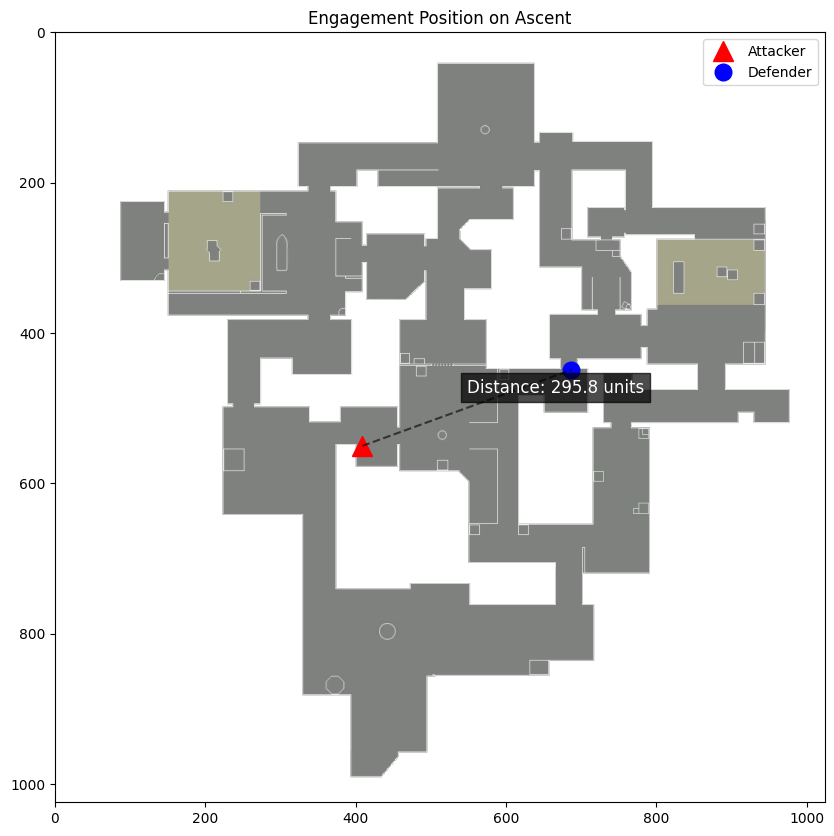

In [ ]:
# Example: Predicting an engagement on Ascent in early round
result = predict_duel(
    model=models["ascent"],
    attacker_pos=(409, 550),     # Attacking player"s position 
    defender_pos=(687, 449),     # Defending player"s position
    attacker_loadout=4200,       # Attacker with full buy (rifle)
    defender_loadout=2900,       # Defender with force buy (SMG)
    round_time=30000,            # 15 seconds into the round (early)
    plant_time=None,            # Bomb not planted
    attacker_weapon_id=4,        # Vandal (mid-long range)
    defender_weapon_id=3        # Spectre (short-mid range)
)

print(f"Prediction: {result['prediction']}")
print(f"Attacker win probability: {result['attacker_win_probability']:.2%}")
print(f"Defender win probability: {result['defender_win_probability']:.2%}")

# Details about the engagement
print(f"\nDistance between players: {result['features_used']['positions']['distance']:.1f} units")
print(f"Economic advantage: {result['features_used']['economy']['advantage']}")
print(f"Round phase: {result['features_used']['timing']['phase']} (advantage: {result['features_used']['timing']['advantage_side']})")
print(f"Weapon matchup: {result['features_used']['weapons']['advantage']}")

plot_positions_on_map("ascent", 
                      attacker_pos=result['features_used']['positions']['attacker'],
                      defender_pos=result['features_used']['positions']['defender'])